In [31]:
pip install pandas numpy statsmodels matplotlib

**Import Libraries**

In [32]:
import json
import string
import os
import gzip

import numpy as np
import pandas as pd

import seaborn as sns

import random

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta
from dateutil import tz


import matplotlib.pyplot as plt
import statsmodels.api as sm


**Far-right Dataset**

In [33]:
#Load dataset for 12 months of 2020,2021,2022
all_file_paths = []


all_file_paths.append([ '/content/2020-01_user_tweets.json.gz', '/content/2020-02_user_tweets.json.gz', '/content/2020-03_user_tweets.json.gz', '/content/2020-04_user_tweets.json.gz', '/content/2020-05_user_tweets.json.gz', '/content/2020-06_user_tweets.json.gz','/content/2020-07_user_tweets.json.gz', '/content/2020-08_user_tweets.json.gz', '/content/2020-09_user_tweets.json.gz', '/content/2020-10_user_tweets.json.gz', '/content/2020-11_user_tweets.json.gz','/content/2020-12_user_tweets.json.gz'])
all_file_paths.append(['/content/2021-01_user_tweets.json.gz', '/content/2021-02_user_tweets.json.gz', '/content/2021-03_user_tweets.json.gz', '/content/2021-04_user_tweets.json.gz', '/content/2021-05_user_tweets.json.gz', '/content/2021-06_user_tweets.json.gz','/content/2021-07_user_tweets.json.gz', '/content/2021-08_user_tweets.json.gz', '/content/2021-09_user_tweets.json.gz', '/content/2021-10_user_tweets.json.gz', '/content/2021-11_user_tweets.json.gz','/content/2021-12_user_tweets.json.gz'])
all_file_paths.append([ '/content/2022-01_user_tweets.json.gz', '/content/2022-02_user_tweets.json.gz', '/content/2022-03_user_tweets.json.gz', '/content/2022-04_user_tweets.json.gz', '/content/2022-05_user_tweets.json.gz', '/content/2022-06_user_tweets.json.gz', '/content/2022-07_user_tweets.json.gz', '/content/2022-08_user_tweets.json.gz', '/content/2022-09_user_tweets.json.gz', '/content/2022-10_user_tweets.json.gz', '/content/2022-11_user_tweets.json.gz'])


all_tweets = [[], [], []]


for year_index in range(3):
 # Iterate through each file path
 for in_file_path in all_file_paths[year_index]:

     with gzip.open(in_file_path, 'rt') as in_file:
         for line in in_file:
             all_tweets[year_index].append(json.loads(line))







all_tweets_df = []


for year_index in range(3):
 all_tweets_df.append(pd.DataFrame(all_tweets[year_index]))
 print(f"Tweets of {2020+year_index}:", len(all_tweets[year_index]))

Tweets of 2020: 56454
Tweets of 2021: 46136
Tweets of 2022: 44722


In [34]:
# Let's check the name of the columns
all_tweets_df[0].columns

Index(['in_reply_to_status_id_str', 'in_reply_to_status_id', 'created_at',
       'in_reply_to_user_id_str', 'source', 'retweet_count', 'retweeted',
       'geo', 'filter_level', 'in_reply_to_screen_name', 'is_quote_status',
       'id_str', 'in_reply_to_user_id', 'favorite_count', 'id', 'text',
       'place', 'lang', 'quote_count', 'favorited', 'coordinates', 'truncated',
       'timestamp_ms', 'reply_count', 'entities', 'display_text_range',
       'contributors', 'user', 'quoted_status', 'retweeted_status',
       'quoted_status_id', 'quoted_status_permalink', 'quoted_status_id_str',
       'possibly_sensitive', 'extended_entities', 'extended_tweet',
       'withheld_in_countries'],
      dtype='object')

**Finding Follower Count and Tweet Count for far-right**

In [35]:
# Combine all tweet DataFrames into one
combined_tweets_df = pd.concat(all_tweets_df, ignore_index=True)

# List of user IDs to filter
accounts_list = [
    '1042263277835677701', '1103451206616150017', '1157848416279396352',
    '1169054965072941059', '1180105262025207808', '1232756300263522304',
    '1295377965438644235', '1317644011', '1335114619132596224',
    '1362497955001896961', '1407687892755963909', '1431519995868106753',
    '1440809899500335110', '1492270474855866368', '1505533038',
    '16573142', '2442725460', '2791988124', '38196838', '409687240',
    '4170889399', '4822059899', '49210987', '67433637',
    '719365655066095616', '826419253347745792', '863755312033021952',
    '871883751508377602', '949510565185155072', '950558867099824128',
    '967034117643579393'
]


combined_tweets_df['user_id'] = combined_tweets_df['user'].apply(
    lambda x: str(x['id']) if isinstance(x, dict) and 'id' in x else None
)
combined_tweets = combined_tweets_df[combined_tweets_df['user_id'].isin(accounts_list)]

# Convert 'created_at' to datetime
combined_tweets['created_at'] = pd.to_datetime(
    combined_tweets['created_at'], format="%a %b %d %H:%M:%S %z %Y"
)

# Get the status count
def get_statuses_count(row):
    if 'is_retweet' in row and row['is_retweet']:
        return row['retweeted_status']['user'].get('statuses_count', None) if 'retweeted_status' in row and isinstance(row['retweeted_status'], dict) and 'user' in row['retweeted_status'] else None
    else:
        return row['user'].get('statuses_count', None) if isinstance(row['user'], dict) else None

combined_tweets['statuses_count'] = combined_tweets.apply(get_statuses_count, axis=1)
combined_tweets['statuses_count'] = pd.to_numeric(combined_tweets['statuses_count'], errors='coerce')


daily_statuses_count = combined_tweets.groupby(['created_at', 'user_id'])['statuses_count'].max()


statuses_count_per_day = daily_statuses_count.unstack(level='user_id')

# Get the follower count
def get_follower_count(row):
    if 'is_retweet' in row and row['is_retweet']:
        return row['retweeted_status']['user'].get('followers_count', None) if 'retweeted_status' in row and isinstance(row['retweeted_status'], dict) and 'user' in row['retweeted_status'] else None
    else:
        return row['user'].get('followers_count', None) if isinstance(row['user'], dict) else None

combined_tweets['followers_count'] = combined_tweets.apply(get_follower_count, axis=1)
combined_tweets['followers_count'] = pd.to_numeric(combined_tweets['followers_count'], errors='coerce')


daily_max_followers = combined_tweets.groupby(['created_at', 'user_id'])['followers_count'].max()

final_follower_count_df = daily_max_followers.unstack(level='user_id')

statuses_count_per_day.to_csv('statuses_count_per_day_farright_count_df.csv', index=True)
final_follower_count_df.to_csv('final_follower_farright_count_df.csv', index=True)

<ipython-input-35-27803444151c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_tweets['created_at'] = pd.to_datetime(
<ipython-input-35-27803444151c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_tweets['statuses_count'] = combined_tweets.apply(get_statuses_count, axis=1)
<ipython-input-35-27803444151c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

**Finding far-right change in follower count**

In [36]:

file_path = 'final_follower_farright_count_df.csv'
follower_data = pd.read_csv(file_path)


follower_data.set_index(follower_data.columns[0], inplace=True)
follower_data.index = pd.to_datetime(follower_data.index)

# Calculate the daily change in followers
change_in_followers = follower_data.diff()

# Replace any NaN values with zeros
change_in_followers = change_in_followers.fillna(0)


change_in_followers.to_csv('change_in_farright_followers.csv')

print(change_in_followers.head(60))

                           1042263277835677701  1103451206616150017  \
created_at                                                            
2020-01-01 04:39:54+00:00                  0.0                  0.0   
2020-01-01 04:59:25+00:00                  0.0                  0.0   
2020-01-01 14:54:25+00:00                  0.0                  0.0   
2020-01-01 18:00:15+00:00                  0.0                  0.0   
2020-01-02 13:39:49+00:00                  0.0                  0.0   
2020-01-02 14:49:02+00:00                  0.0                  0.0   
2020-01-02 22:14:41+00:00                  2.0                  0.0   
2020-01-02 22:16:55+00:00                  0.0                  0.0   
2020-01-03 01:16:18+00:00                  0.0                  0.0   
2020-01-03 02:21:51+00:00                  0.0                  0.0   
2020-01-03 05:31:31+00:00                  0.0                  0.0   
2020-01-03 16:36:35+00:00                  0.0                  0.0   
2020-0

**Plotting follower count for far-right**

In [37]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt

combined_tweets_df = pd.concat(all_tweets_df, ignore_index=True)

# List of user IDs to filter
accounts_list = [
    '1042263277835677701', '1103451206616150017', '1157848416279396352',
    '1169054965072941059', '1180105262025207808', '1232756300263522304',
    '1295377965438644235', '1317644011', '1335114619132596224',
    '1362497955001896961', '1407687892755963909', '1431519995868106753',
    '1440809899500335110', '1492270474855866368', '1505533038',
    '16573142', '2442725460', '2791988124', '38196838', '409687240',
    '4170889399', '4822059899', '49210987', '67433637',
    '719365655066095616', '826419253347745792', '863755312033021952',
    '871883751508377602', '949510565185155072', '950558867099824128',
    '967034117643579393'
]

combined_tweets_df['user_id'] = combined_tweets_df['user'].apply(
    lambda x: str(x['id']) if isinstance(x, dict) and 'id' in x else None
)
combined_tweets = combined_tweets_df[combined_tweets_df['user_id'].isin(accounts_list)]

# Get the follower count
def get_follower_count(row):
    if 'is_retweet' in row and row['is_retweet']:
        return row['retweeted_status']['user'].get('followers_count', None) if 'retweeted_status' in row and isinstance(row['retweeted_status'], dict) and 'user' in row['retweeted_status'] else None
    else:
        return row['user'].get('followers_count', None) if isinstance(row['user'], dict) else None

combined_tweets['followers_count'] = combined_tweets.apply(get_follower_count, axis=1)


combined_tweets['followers_count'] = pd.to_numeric(combined_tweets['followers_count'], errors='coerce')


combined_tweets['date'] = pd.to_datetime(combined_tweets['created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.date


date_range = pd.date_range(start='2020-01-01', end='2022-11-21')


daily_max_followers = combined_tweets.groupby(['date', 'user_id'])['followers_count'].max().unstack(level='user_id')


daily_max_followers = daily_max_followers.reindex(date_range).fillna(method='ffill')

os.makedirs('images', exist_ok=True)

# Plotting the data for each account
for account in accounts_list:
    plt.figure(figsize=(10, 6))
    plt.plot(daily_max_followers.index, daily_max_followers[account], label=f'Account {account}')
    plt.xlabel('Date')
    plt.ylabel('Number of Followers per Day')
    plt.legend()
    plt.grid(True)
    file_path = f'images/far_right_followers_{account}.png'
    plt.savefig(file_path)
    plt.close()

shutil.make_archive('followers_images', 'zip', 'images')

print("All images have been saved and zipped as 'followers_images.zip'.")


<ipython-input-37-0b11deb23f9c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_tweets['followers_count'] = combined_tweets.apply(get_follower_count, axis=1)
<ipython-input-37-0b11deb23f9c>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_tweets['followers_count'] = pd.to_numeric(combined_tweets['followers_count'], errors='coerce')
<ipython-input-37-0b11deb23f9c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

All images have been saved and zipped as 'followers_images.zip'.


**Plotting tweet count for far-right**

In [38]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt


combined_tweets_df = pd.concat(all_tweets_df, ignore_index=True)


accounts_list = [
    '1042263277835677701', '1103451206616150017', '1157848416279396352',
    '1169054965072941059', '1180105262025207808', '1232756300263522304',
    '1295377965438644235', '1317644011', '1335114619132596224',
    '1362497955001896961', '1407687892755963909', '1431519995868106753',
    '1440809899500335110', '1492270474855866368', '1505533038',
    '16573142', '2442725460', '2791988124', '38196838', '409687240',
    '4170889399', '4822059899', '49210987', '67433637',
    '719365655066095616', '826419253347745792', '863755312033021952',
    '871883751508377602', '949510565185155072', '950558867099824128',
    '967034117643579393'
]

combined_tweets_df['user_id'] = combined_tweets_df['user'].apply(
    lambda x: str(x['id']) if isinstance(x, dict) and 'id' in x else None
)
combined_tweets = combined_tweets_df[combined_tweets_df['user_id'].isin(accounts_list)]


combined_tweets['date'] = pd.to_datetime(combined_tweets['created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.date

# Get the status count
def get_statuses_count(row):
    if 'is_retweet' in row and row['is_retweet']:
        return row['retweeted_status']['user'].get('statuses_count', None) if 'retweeted_status' in row and isinstance(row['retweeted_status'], dict) and 'user' in row['retweeted_status'] else None
    else:
        return row['user'].get('statuses_count', None) if isinstance(row['user'], dict) else None

combined_tweets['statuses_count'] = combined_tweets.apply(get_statuses_count, axis=1)

combined_tweets['statuses_count'] = pd.to_numeric(combined_tweets['statuses_count'], errors='coerce')


daily_statuses_count = combined_tweets.groupby(['date', 'user_id'])['statuses_count'].max()


statuses_count_per_day = daily_statuses_count.unstack(level='user_id')

date_range = pd.date_range(start='2020-01-01', end='2022-11-21')
statuses_count_per_day = statuses_count_per_day.reindex(date_range).rename_axis('date').reset_index()

# Forward fill the statuses count
statuses_count_per_day = statuses_count_per_day.ffill()

os.makedirs('statuses_images', exist_ok=True)

# Plotting the data for each account
for account in accounts_list:
    plt.figure(figsize=(10, 6))
    plt.plot(statuses_count_per_day['date'], statuses_count_per_day[account], label=f'Account {account}')
    plt.xlabel('Date')
    plt.ylabel('Tweet Count per Day')
    plt.legend()
    plt.grid(True)
    file_path = f'statuses_images/statuses_count_over_time_{account}.png'
    plt.savefig(file_path)
    plt.close()

shutil.make_archive('statuses_images_archive', 'zip', 'statuses_images')

print("All images have been saved and zipped as 'statuses_images_archive.zip'.")


<ipython-input-38-4c0d6dcb6ed8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_tweets['date'] = pd.to_datetime(combined_tweets['created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.date
<ipython-input-38-4c0d6dcb6ed8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_tweets['statuses_count'] = combined_tweets.apply(get_statuses_count, axis=1)
<ipython-input-38-4c0d6dcb6ed8>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

All images have been saved and zipped as 'statuses_images_archive.zip'.


**MLA Dataset**

In [39]:
#Load dataset for 12 months of 2020,2021,2022
all_file_paths = []


all_file_paths.append([ '/content/2020_user_tweets.json.gz'])
all_file_paths.append(['/content/2021_user_tweets.json.gz'])
all_file_paths.append(['/content/2022_user_tweets.json.gz'])


mla_tweets = [[], [], []]


for year_index in range(3):

 for in_file_path in all_file_paths[year_index]:

     with gzip.open(in_file_path, 'rt') as in_file:
         for line in in_file:
            mla_tweets[year_index].append(json.loads(line))







mla_tweets_df = []


for year_index in range(3):
 mla_tweets_df.append(pd.DataFrame(mla_tweets[year_index]))
 print(f"Tweets of {2020+year_index}:", len(mla_tweets[year_index]))

Tweets of 2020: 2247
Tweets of 2021: 3635
Tweets of 2022: 5512


**Finding Follower Count and Tweet Count for MLA**

In [40]:
# Combine all MLA tweet DataFrames into one
combined_mlatweets_df = pd.concat(mla_tweets_df, ignore_index=True)

# List of user IDs to filter
accounts_list = [
    '204646101', '24118540', '274296872', '215367878', '2451785366', '365194541',
    '191881051', '258658533', '562500503', '2490932353', '2761310294',
    '3193685550', '2395387314', '984612908234555393', '1167532349447462913',
    '29877350', '3310629576', '2851627191', '1291139322003853313', '35532191',
    '2745325906', '1894414951', '2987178668', '1549144973509107717', '802649408'
]


combined_mlatweets_df['user_id'] = combined_mlatweets_df['user'].apply(
    lambda x: str(x['id']) if isinstance(x, dict) and 'id' in x else None
)
combined_mlatweets = combined_mlatweets_df[combined_mlatweets_df['user_id'].isin(accounts_list)]

# Convert 'created_at' to datetime
combined_mlatweets['created_at'] = pd.to_datetime(
    combined_mlatweets['created_at'], format="%a %b %d %H:%M:%S %z %Y"
)

# Get the status count
def get_statuses_count(row):
    if 'is_retweet' in row and row['is_retweet']:
        return row['retweeted_status']['user'].get('statuses_count', None) if 'retweeted_status' in row and isinstance(row['retweeted_status'], dict) and 'user' in row['retweeted_status'] else None
    else:
        return row['user'].get('statuses_count', None) if isinstance(row['user'], dict) else None

combined_mlatweets['statuses_count'] = combined_mlatweets.apply(get_statuses_count, axis=1)
combined_mlatweets['statuses_count'] = pd.to_numeric(combined_mlatweets['statuses_count'], errors='coerce')
t
daily_statuses_count = combined_mlatweets.groupby(['created_at', 'user_id'])['statuses_count'].max()


statuses_count_per_day = daily_statuses_count.unstack(level='user_id')

# Get the follower count
def get_follower_count(row):
    if 'is_retweet' in row and row['is_retweet']:
        return row['retweeted_status']['user'].get('followers_count', None) if 'retweeted_status' in row and isinstance(row['retweeted_status'], dict) and 'user' in row['retweeted_status'] else None
    else:
        return row['user'].get('followers_count', None) if isinstance(row['user'], dict) else None

combined_mlatweets['followers_count'] = combined_mlatweets.apply(get_follower_count, axis=1)
combined_mlatweets['followers_count'] = pd.to_numeric(combined_mlatweets['followers_count'], errors='coerce')

daily_max_followers = combined_mlatweets.groupby(['created_at', 'user_id'])['followers_count'].max()


final_follower_mla_count_df = daily_max_followers.unstack(level='user_id')


statuses_count_per_day.to_csv('statuses_count_per_day_mla_count_df.csv', index=True)
final_follower_mla_count_df.to_csv('final_follower_mla_count_df.csv', index=True)


<ipython-input-40-aa7e5af10de5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_mlatweets['created_at'] = pd.to_datetime(
<ipython-input-40-aa7e5af10de5>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_mlatweets['statuses_count'] = combined_mlatweets.apply(get_statuses_count, axis=1)
<ipython-input-40-aa7e5af10de5>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

**Finding MLA change in follower count**

In [41]:

file_path = 'final_follower_mla_count_df.csv'
follower_data = pd.read_csv(file_path)

follower_data.set_index(follower_data.columns[0], inplace=True)
follower_data.index = pd.to_datetime(follower_data.index)

# Calculate the daily change in followers
change_in_followers = follower_data.diff()

change_in_followers = change_in_followers.fillna(0)


change_in_followers.to_csv('change_in_mla_followers.csv')

print(change_in_followers.head(60))


                           1167532349447462913  1291139322003853313  \
created_at                                                            
2020-01-02 18:19:24+00:00                  0.0                  0.0   
2020-01-05 04:24:47+00:00                  0.0                  0.0   
2020-01-06 11:52:33+00:00                  0.0                  0.0   
2020-01-07 15:54:05+00:00                  0.0                  0.0   
2020-01-09 01:23:40+00:00                  0.0                  0.0   
2020-01-15 15:35:36+00:00                  0.0                  0.0   
2020-01-16 21:40:08+00:00                  0.0                  0.0   
2020-01-23 11:47:44+00:00                  0.0                  0.0   
2020-01-25 17:49:55+00:00                  0.0                  0.0   
2020-01-28 23:22:05+00:00                  0.0                  0.0   
2020-02-03 19:07:04+00:00                  0.0                  0.0   
2020-02-12 10:26:24+00:00                  0.0                  0.0   
2020-0

**Plotting follower count for MLA**

In [42]:
import os
import shutil
import matplotlib.pyplot as plt


combined_mlatweets_df = pd.concat(mla_tweets_df, ignore_index=True)


accounts_list = [
    '204646101', '24118540', '274296872', '215367878', '2451785366', '365194541',
    '191881051', '258658533', '562500503', '2490932353', '2761310294',
    '3193685550', '2395387314', '984612908234555393', '1167532349447462913',
    '29877350', '3310629576', '2851627191', '1291139322003853313', '35532191',
    '2745325906', '1894414951', '2987178668', '1549144973509107717', '802649408'
]


combined_mlatweets_df['user_id'] = combined_mlatweets_df['user'].apply(
    lambda x: str(x['id']) if isinstance(x, dict) and 'id' in x else None
)
combined_mlatweets = combined_mlatweets_df[combined_mlatweets_df['user_id'].isin(accounts_list)]

# Get the follower count
def get_follower_count(row):
    if 'is_retweet' in row and row['is_retweet']:
        return row['retweeted_status']['user'].get('followers_count', None) if 'retweeted_status' in row and isinstance(row['retweeted_status'], dict) and 'user' in row['retweeted_status'] else None
    else:
        return row['user'].get('followers_count', None) if isinstance(row['user'], dict) else None

combined_mlatweets['followers_count'] = combined_mlatweets.apply(get_follower_count, axis=1)

combined_mlatweets['followers_count'] = pd.to_numeric(combined_mlatweets['followers_count'], errors='coerce')

combined_mlatweets['date'] = pd.to_datetime(combined_mlatweets['created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.date

date_range = pd.date_range(start='2020-01-01', end='2022-11-21')

daily_max_followers = combined_mlatweets.groupby(['date', 'user_id'])['followers_count'].max().unstack(level='user_id')

daily_max_followers = daily_max_followers.reindex(date_range).fillna(method='ffill')

os.makedirs('mla_followers_images', exist_ok=True)

# Plotting the data for each account
for account in accounts_list:
    plt.figure(figsize=(10, 6))
    plt.plot(daily_max_followers.index, daily_max_followers[account], label=f'Account {account}')
    plt.xlabel('Date')
    plt.ylabel('Number of Followers per Day')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'mla_followers_images/mla_followers_{account}.png')
    plt.close()


shutil.make_archive('mla_followers_images_archive', 'zip', 'mla_followers_images')

print("All images have been saved and zipped as 'mla_followers_images_archive.zip'.")



<ipython-input-42-bafdd3e149b8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_mlatweets['followers_count'] = combined_mlatweets.apply(get_follower_count, axis=1)
<ipython-input-42-bafdd3e149b8>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_mlatweets['followers_count'] = pd.to_numeric(combined_mlatweets['followers_count'], errors='coerce')
<ipython-input-42-bafdd3e149b8>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

All images have been saved and zipped as 'mla_followers_images_archive.zip'.


**Plotting tweet count for MLA**

In [43]:
import os
import shutil
import matplotlib.pyplot as plt

# Combine all MLA tweet DataFrames into one
combined_mlatweets_df = pd.concat(mla_tweets_df, ignore_index=True)

# List of user IDs to filter
accounts_list = [
    '204646101', '24118540', '274296872', '215367878', '2451785366', '365194541',
    '191881051', '258658533', '562500503', '2490932353', '2761310294',
    '3193685550', '2395387314', '984612908234555393', '1167532349447462913',
    '29877350', '3310629576', '2851627191', '1291139322003853313', '35532191',
    '2745325906', '1894414951', '2987178668', '1549144973509107717', '802649408'
]


combined_mlatweets_df['user_id'] = combined_mlatweets_df['user'].apply(
    lambda x: str(x['id']) if isinstance(x, dict) and 'id' in x else None
)
combined_mlatweets = combined_mlatweets_df[combined_mlatweets_df['user_id'].isin(accounts_list)]


combined_mlatweets['date'] = pd.to_datetime(combined_mlatweets['created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.date

# Get the status count
def get_statuses_count(row):
    if 'is_retweet' in row and row['is_retweet']:
        return row['retweeted_status']['user'].get('statuses_count', None) if 'retweeted_status' in row and isinstance(row['retweeted_status'], dict) and 'user' in row['retweeted_status'] else None
    else:
        return row['user'].get('statuses_count', None) if isinstance(row['user'], dict) else None

combined_mlatweets['statuses_count'] = combined_mlatweets.apply(get_statuses_count, axis=1)
combined_mlatweets['statuses_count'] = pd.to_numeric(combined_mlatweets['statuses_count'], errors='coerce')


daily_statuses_count = combined_mlatweets.groupby(['date', 'user_id'])['statuses_count'].max()


statuses_count_per_day = daily_statuses_count.unstack(level='user_id')


date_range = pd.date_range(start='2020-01-01', end='2022-11-21')
statuses_count_per_day = statuses_count_per_day.reindex(date_range).rename_axis('date').reset_index()


statuses_count_per_day = statuses_count_per_day.ffill()


os.makedirs('mla_statuses_count_images', exist_ok=True)

# Plotting the data for each account
for account in accounts_list:
    plt.figure(figsize=(10, 6))
    plt.plot(statuses_count_per_day['date'], statuses_count_per_day[account], label=f'Account {account}')
    plt.xlabel('Date')
    plt.ylabel('Tweet Count per Day')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'mla_statuses_count_images/mla_statuses_count_over_time_{account}.png')
    plt.close()


shutil.make_archive('mla_statuses_count_images_archive', 'zip', 'mla_statuses_count_images')

print("All images have been saved and zipped as 'mla_statuses_count_images_archive.zip'.")


<ipython-input-43-1d40e9c3faf3>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_mlatweets['date'] = pd.to_datetime(combined_mlatweets['created_at'], format="%a %b %d %H:%M:%S %z %Y").dt.date
<ipython-input-43-1d40e9c3faf3>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_mlatweets['statuses_count'] = combined_mlatweets.apply(get_statuses_count, axis=1)
<ipython-input-43-1d40e9c3faf3>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

All images have been saved and zipped as 'mla_statuses_count_images_archive.zip'.


**Daily average change in followers MLA Vs Far-right**

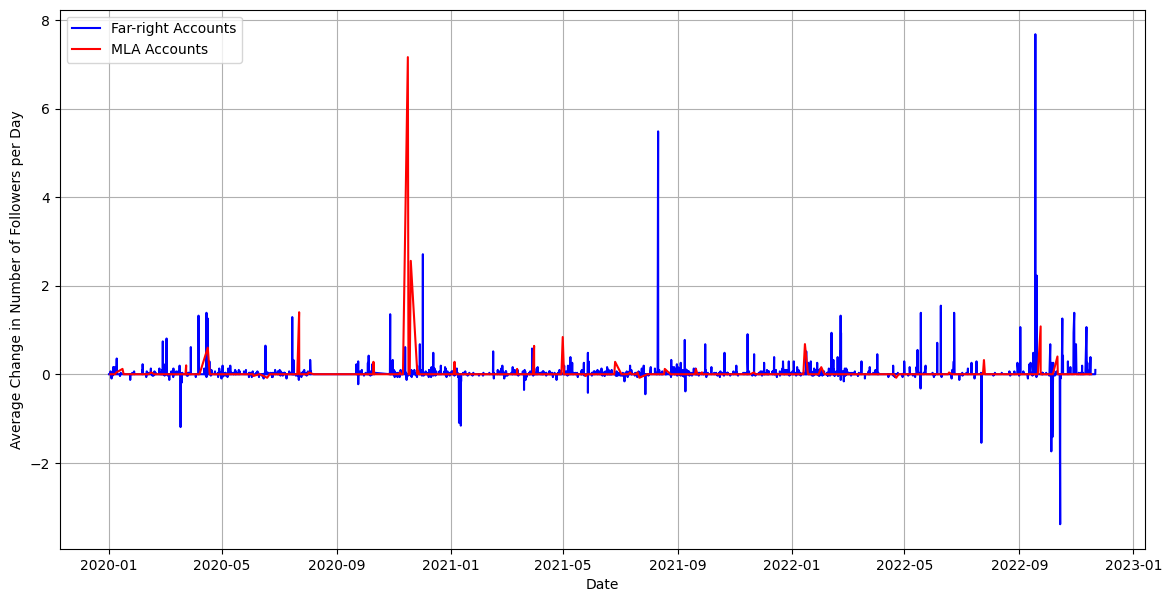

In [44]:


far_right_change_file_path = 'change_in_farright_followers.csv'
far_right_change_df = pd.read_csv(far_right_change_file_path)


mla_change_file_path = 'change_in_mla_followers.csv'
mla_change_df = pd.read_csv(mla_change_file_path)


far_right_change_df.set_index(far_right_change_df.columns[0], inplace=True)
far_right_change_df.index = pd.to_datetime(far_right_change_df.index)

mla_change_df.set_index(mla_change_df.columns[0], inplace=True)
mla_change_df.index = pd.to_datetime(mla_change_df.index)

# Create a plot to compare the daily changes
plt.figure(figsize=(14, 7))

# Plot the average daily change in followers for far-right accounts
plt.plot(far_right_change_df.index, far_right_change_df.mean(axis=1), label='Far-right Accounts', color='blue')

# Plot the average daily change in followers for MLA accounts
plt.plot(mla_change_df.index, mla_change_df.mean(axis=1), label='MLA Accounts', color='red')

plt.xlabel('Date')
plt.ylabel('Average Change in Number of Followers per Day')
#plt.title('Daily Change in Followers Over Time')
plt.legend()

plt.grid(True)
plt.savefig(f'changeinfollowers.png')

plt.show()


Weekly average change in followers MLA Vs Far-right

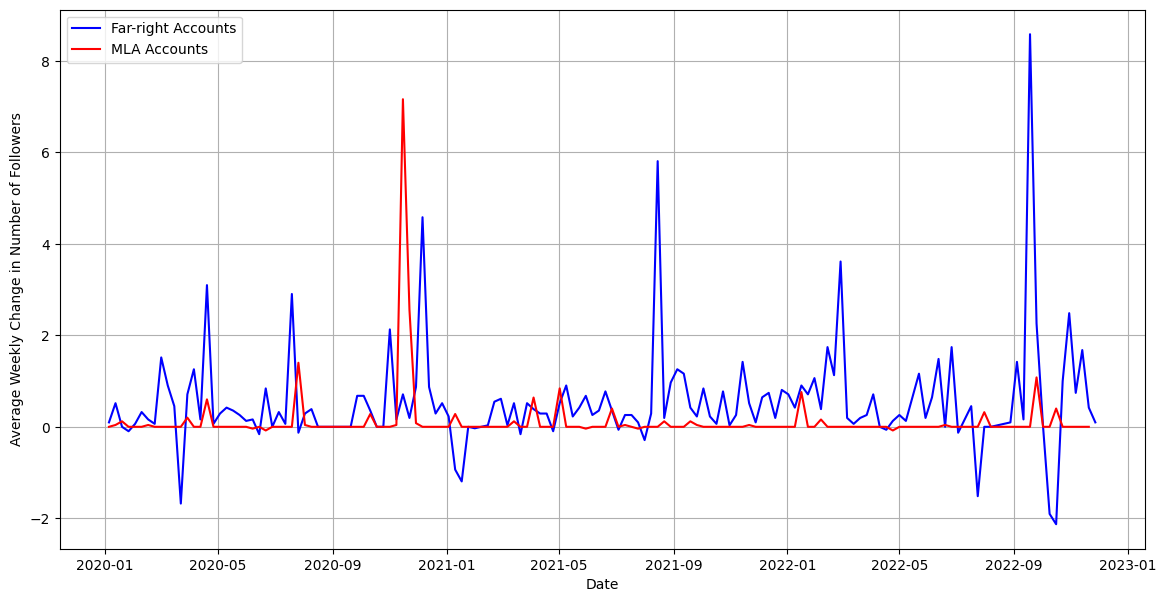

In [45]:
import pandas as pd
import matplotlib.pyplot as plt


far_right_change_file_path = 'change_in_farright_followers.csv'
far_right_change_df = pd.read_csv(far_right_change_file_path)


mla_change_file_path = 'change_in_mla_followers.csv'
mla_change_df = pd.read_csv(mla_change_file_path)

far_right_change_df.set_index(far_right_change_df.columns[0], inplace=True)
far_right_change_df.index = pd.to_datetime(far_right_change_df.index)

mla_change_df.set_index(mla_change_df.columns[0], inplace=True)
mla_change_df.index = pd.to_datetime(mla_change_df.index)


far_right_weekly_change_df = far_right_change_df.resample('W').sum()
mla_weekly_change_df = mla_change_df.resample('W').sum()

# Create a plot to compare the weekly changes
plt.figure(figsize=(14, 7))

# Plot the average weekly change in followers for far-right accounts
plt.plot(far_right_weekly_change_df.index, far_right_weekly_change_df.mean(axis=1), label='Far-right Accounts', color='blue')

# Plot the average weekly change in followers for MLA accounts
plt.plot(mla_weekly_change_df.index, mla_weekly_change_df.mean(axis=1), label='MLA Accounts', color='red')

plt.xlabel('Date')
plt.ylabel('Average Weekly Change in Number of Followers')
#plt.title('Weekly Change in Followers Over Time')
plt.legend()

plt.grid(True)
plt.savefig(f'Averageweeklychangeinfollowers.png')
# Display the plot
plt.show()


**Interrupted Time Series Model**

**Intervention Date 1 March 13, 2020 - First health mandate released in SK (social distancing) and business closures began.**

Far-right


Results for 1 months before and after the intervention date:
                            OLS Regression Results                            
Dep. Variable:          log_followers   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.636e+07
Date:                Wed, 27 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:16   Log-Likelihood:                 53811.
No. Observations:               17430   AIC:                        -1.076e+05
Df Residuals:                   17395   BIC:                        -1.073e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

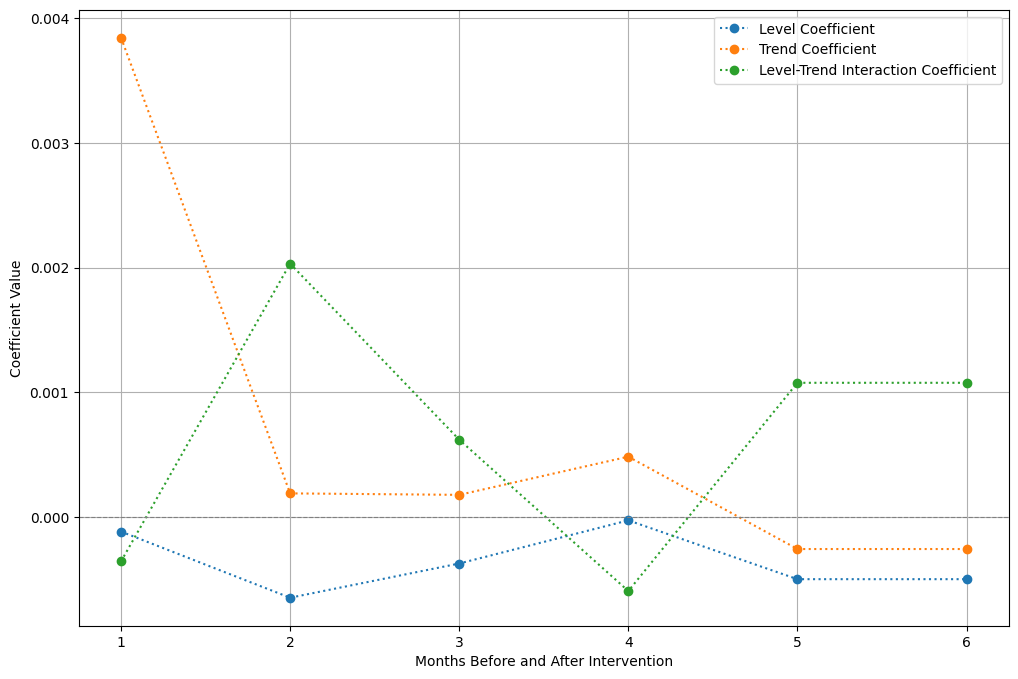

Coefficient visualization saved as 'coefficients_visualization.png'.


In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_farright_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_farright_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2020, 3, 13, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

months_list = [1, 2, 3, 4, 5, 6]

# Lists to store results for visualization
levels, trends, level_trends = [], [], []

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Extract the coefficients for level, trend, and level_trend
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    # Print results
    print(f"\nResults for {months} months before and after the intervention date:")
    print(results.summary())

    return data

# Run the analysis for each time frame
for months in months_list:
    data = run_analysis(months)

# Visualization of Results
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted', label='Level Coefficient')
plt.plot(months_list, trends, marker='o',linestyle='dotted', label='Trend Coefficient')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted', label='Level-Trend Interaction Coefficient')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Coefficients Across Different Time Frames')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('far-right_march132020.png')
plt.show()

print("Coefficient visualization saved as 'coefficients_visualization.png'.")


**March 13 2020 MLA**

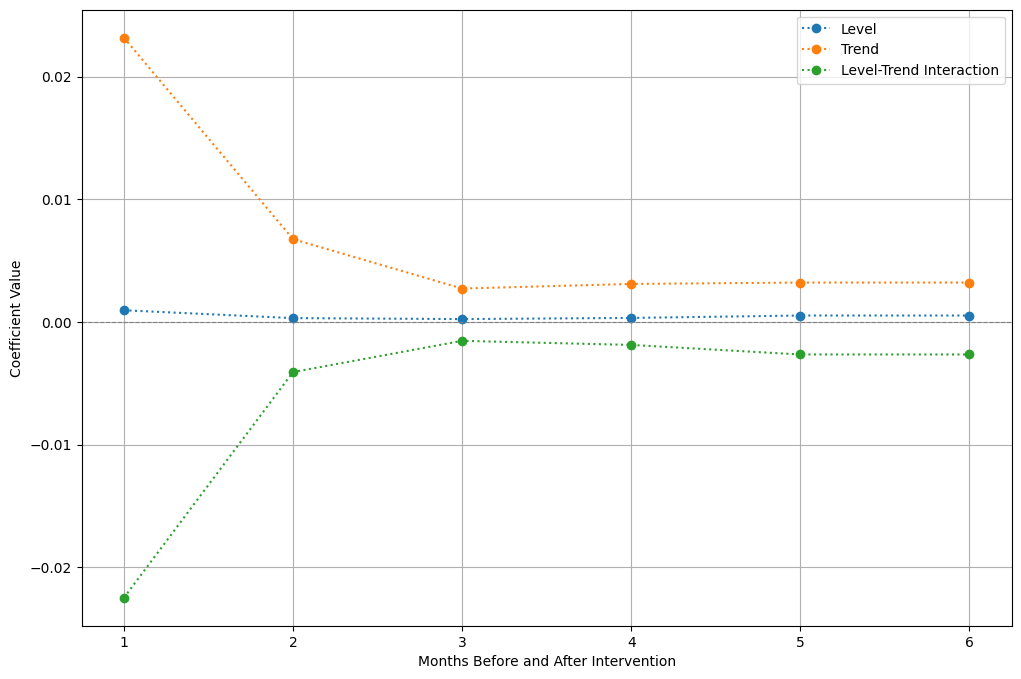

In [48]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_mla_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_mla_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2020, 3, 13, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Lists to store coefficients
levels = []
trends = []
level_trends = []

# Months to analyze
months_list = [1, 2, 3, 4, 5, 6]

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Store coefficients
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    return data

# Run the analysis for each month
for months in months_list:
    data = run_analysis(months)

# Visualization
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted', label='Level')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Effect Coefficients for MLA Accounts')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('mla_march132020.png')
plt.show()




**August 4th 2020 Far-right**


Results for 1 months before and after the intervention date:
                            OLS Regression Results                            
Dep. Variable:          log_followers   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.217e+07
Date:                Wed, 27 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:21   Log-Likelihood:                 33861.
No. Observations:               11520   AIC:                        -6.765e+04
Df Residuals:                   11485   BIC:                        -6.739e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

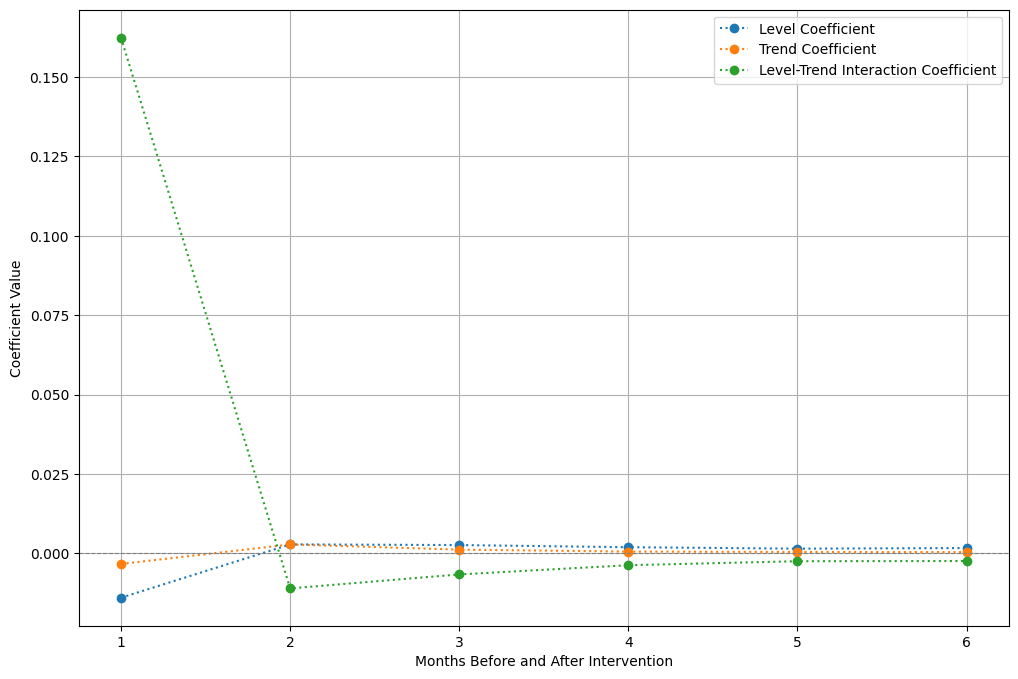

Coefficient visualization saved as 'coefficients_visualization.png'.


In [49]:


# Load data
follower_file_path = '/content/final_follower_farright_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_farright_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2020, 8, 4, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

months_list = [1, 2, 3, 4, 5, 6]

# Lists to store results for visualization
levels, trends, level_trends = [], [], []

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Extract the coefficients for level, trend, and level_trend
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    # Print results
    print(f"\nResults for {months} months before and after the intervention date:")
    print(results.summary())

    return data

# Run the analysis for each time frame
for months in months_list:
    data = run_analysis(months)

# Visualization of Results
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level Coefficient')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend Coefficient')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction Coefficient')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Coefficients Across Different Time Frames')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('far-right_aug42020.png')
plt.show()

print("Coefficient visualization saved as 'coefficients_visualization.png'.")

**August 4th 2020 MLA**

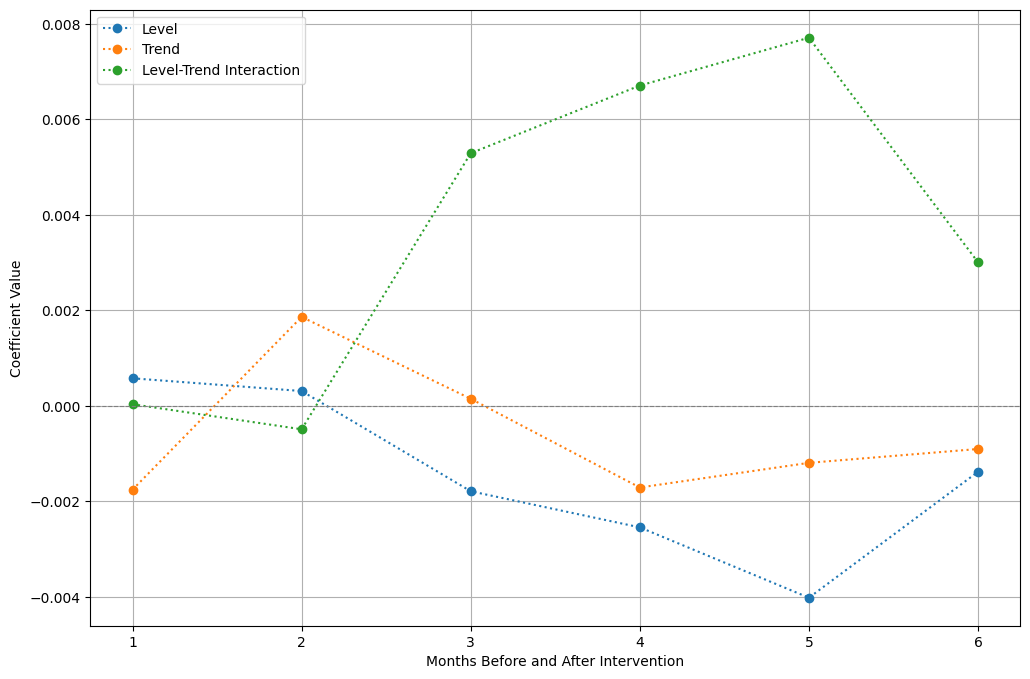

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_mla_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_mla_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2020, 8, 4, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Lists to store coefficients
levels = []
trends = []
level_trends = []

# Months to analyze
months_list = [1, 2, 3, 4, 5, 6]

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Store coefficients
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    return data

# Run the analysis for each month
for months in months_list:
    data = run_analysis(months)

# Visualization
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Effect Coefficients for MLA Accounts')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('mla_aug42020.png')
plt.show()

**November 6th 2020 Far-right**


Results for 1 months before and after the intervention date:
                            OLS Regression Results                            
Dep. Variable:          log_followers   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.214e+09
Date:                Wed, 27 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:25   Log-Likelihood:                 86192.
No. Observations:               18480   AIC:                        -1.723e+05
Df Residuals:                   18445   BIC:                        -1.720e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

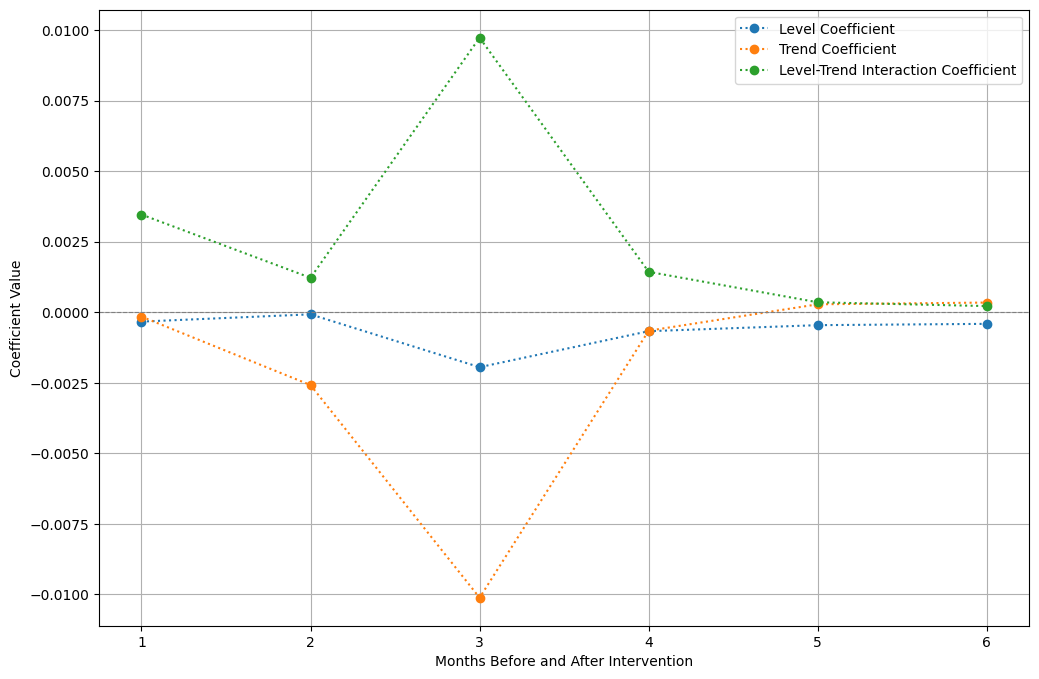

Coefficient visualization saved as 'coefficients_visualization.png'.


In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_farright_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_farright_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2020, 11, 6, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

months_list = [1, 2, 3, 4, 5, 6]

# Lists to store results for visualization
levels, trends, level_trends = [], [], []

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Extract the coefficients for level, trend, and level_trend
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    # Print results
    print(f"\nResults for {months} months before and after the intervention date:")
    print(results.summary())

    return data

# Run the analysis for each time frame
for months in months_list:
    data = run_analysis(months)

# Visualization of Results
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level Coefficient')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend Coefficient')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction Coefficient')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Coefficients Across Different Time Frames')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('far-right_nov62020.png')
plt.show()

print("Coefficient visualization saved as 'coefficients_visualization.png'.")

**November 6th 2020 MLA**

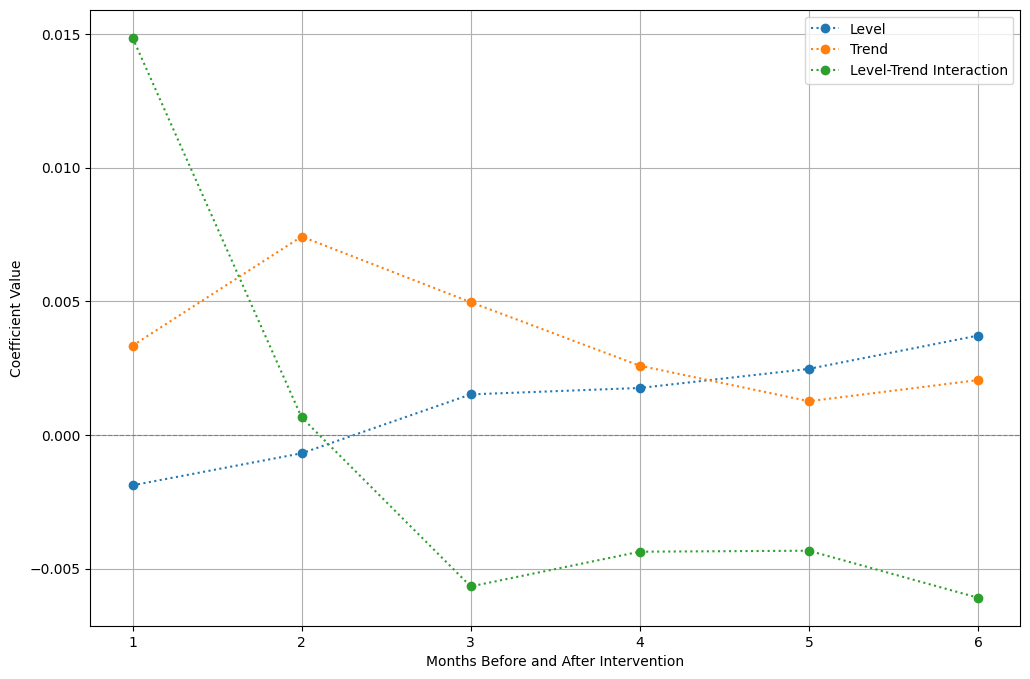

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_mla_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_mla_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2020, 11, 6, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Lists to store coefficients
levels = []
trends = []
level_trends = []

# Months to analyze
months_list = [1, 2, 3, 4, 5, 6]

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Store coefficients
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    return data

# Run the analysis for each month
for months in months_list:
    data = run_analysis(months)

# Visualization
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Effect Coefficients for MLA Accounts')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('mla_nov62020.png')
plt.show()

**November 19th 2020 Far-right**


Results for 1 months before and after the intervention date:
                            OLS Regression Results                            
Dep. Variable:          log_followers   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.066e+09
Date:                Wed, 27 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:29   Log-Likelihood:             1.0393e+05
No. Observations:               21922   AIC:                        -2.078e+05
Df Residuals:                   21887   BIC:                        -2.075e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

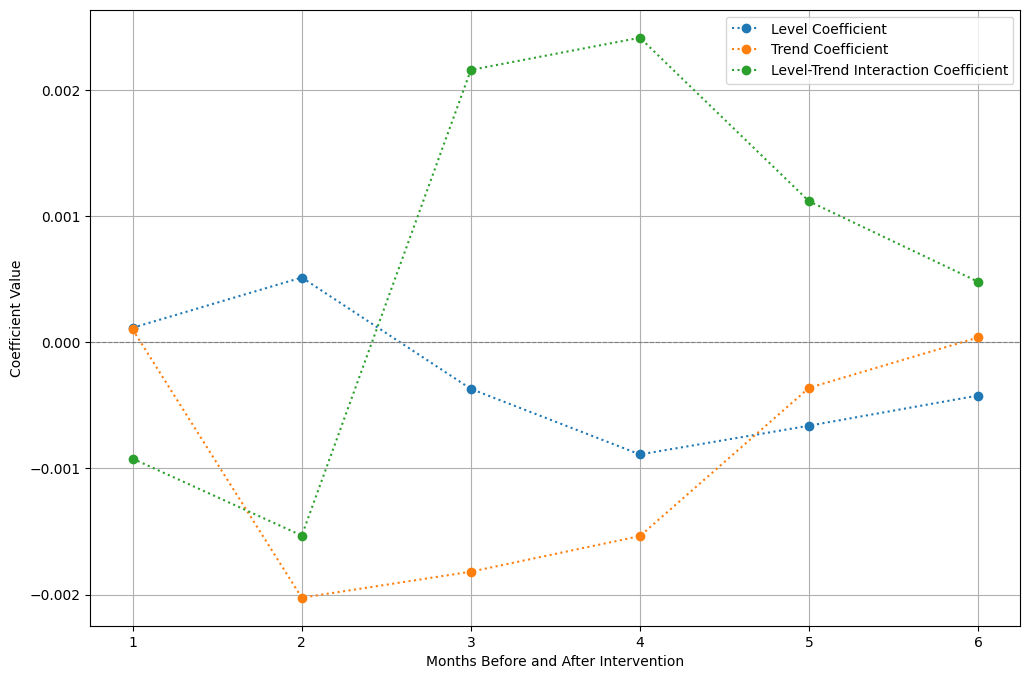

Coefficient visualization saved as 'coefficients_visualization.png'.


In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_farright_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_farright_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2020, 11, 19, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

months_list = [1, 2, 3, 4, 5, 6]

# Lists to store results for visualization
levels, trends, level_trends = [], [], []

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Extract the coefficients for level, trend, and level_trend
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    # Print results
    print(f"\nResults for {months} months before and after the intervention date:")
    print(results.summary())

    return data

# Run the analysis for each time frame
for months in months_list:
    data = run_analysis(months)

# Visualization of Results
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted', label='Level Coefficient')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend Coefficient')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction Coefficient')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Coefficients Across Different Time Frames')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('far-right_nov192020.png')
plt.show()

print("Coefficient visualization saved as 'coefficients_visualization.png'.")

**November 19th 2020 MLA**

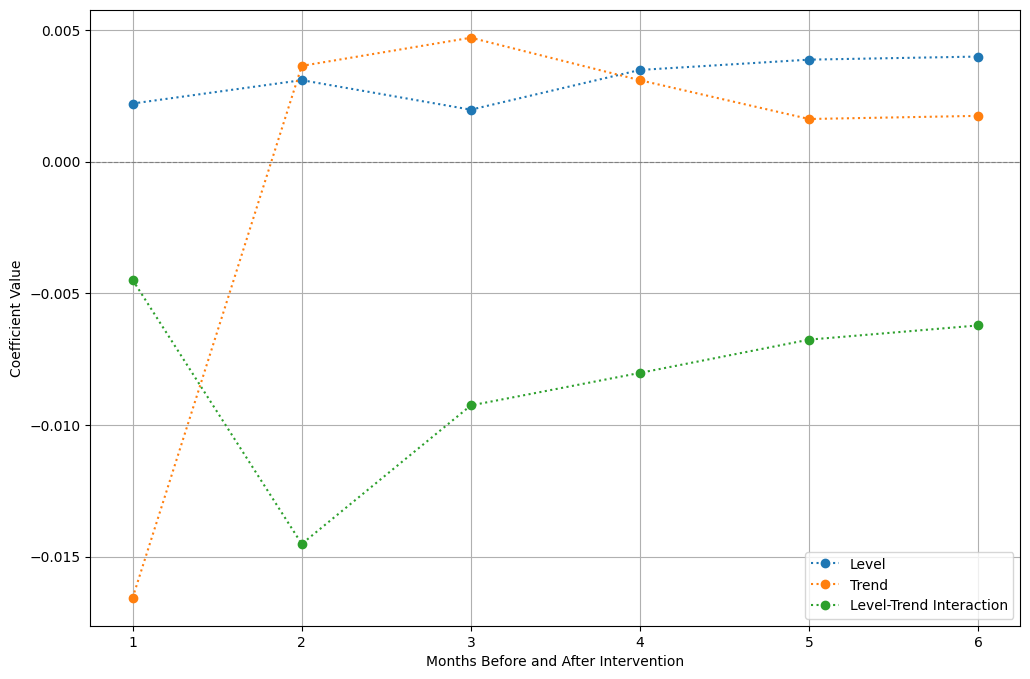

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_mla_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_mla_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2020, 11, 19, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Lists to store coefficients
levels = []
trends = []
level_trends = []

# Months to analyze
months_list = [1, 2, 3, 4, 5, 6]

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Store coefficients
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    return data

# Run the analysis for each month
for months in months_list:
    data = run_analysis(months)

# Visualization
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Effect Coefficients for MLA Accounts')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('mla_nov192020.png')
plt.show()

**January 6th 2021 Far-right**


Results for 1 months before and after the intervention date:
                            OLS Regression Results                            
Dep. Variable:          log_followers   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.312e+08
Date:                Wed, 27 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:35   Log-Likelihood:                 73804.
No. Observations:               23339   AIC:                        -1.475e+05
Df Residuals:                   23304   BIC:                        -1.473e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

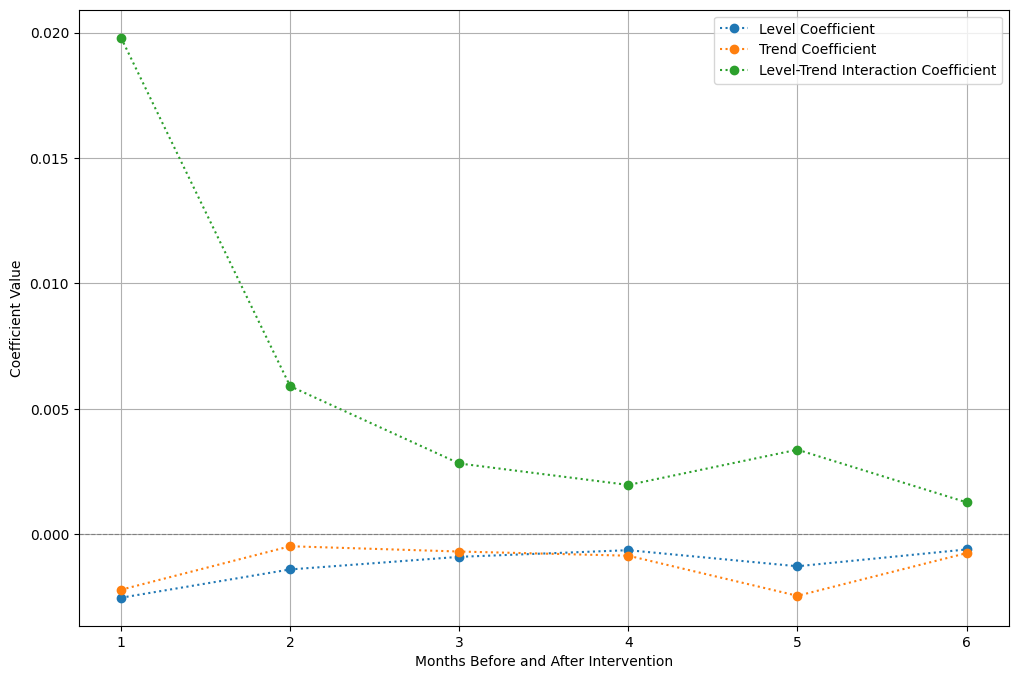

Coefficient visualization saved as 'coefficients_visualization.png'.


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_farright_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_farright_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2021, 1, 6, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

months_list = [1, 2, 3, 4, 5, 6]

# Lists to store results for visualization
levels, trends, level_trends = [], [], []

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Extract the coefficients for level, trend, and level_trend
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    # Print results
    print(f"\nResults for {months} months before and after the intervention date:")
    print(results.summary())

    return data

# Run the analysis for each time frame
for months in months_list:
    data = run_analysis(months)

# Visualization of Results
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level Coefficient')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend Coefficient')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction Coefficient')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Coefficients Across Different Time Frames')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('far-right_jan62021.png')
plt.show()

print("Coefficient visualization saved as 'coefficients_visualization.png'.")

**January 6th 2021 MLA**

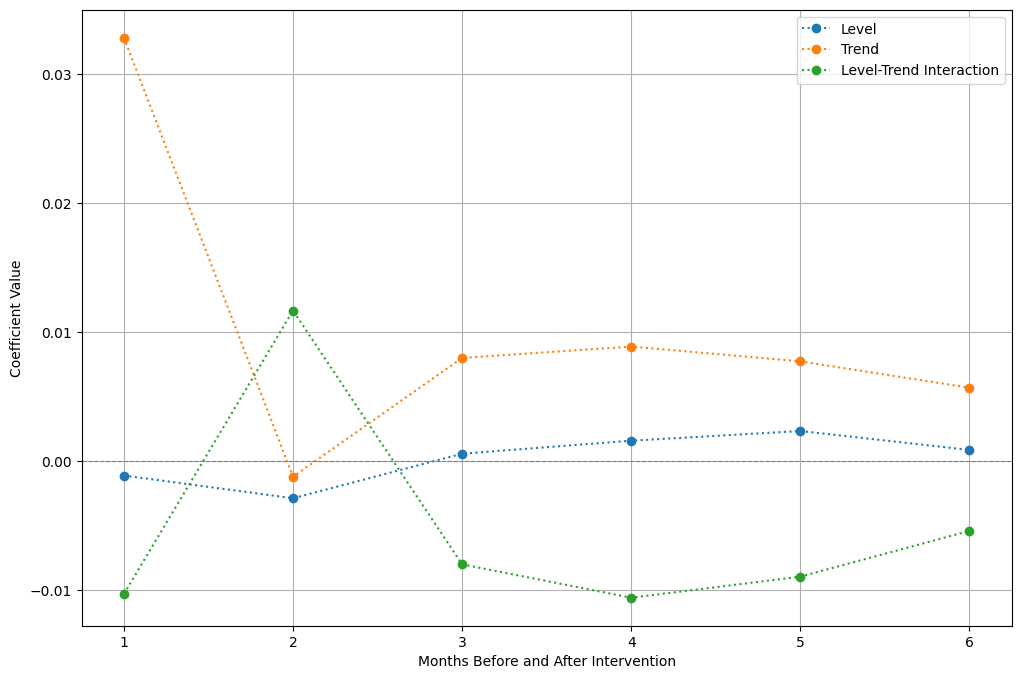

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_mla_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_mla_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2021, 1, 6, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Lists to store coefficients
levels = []
trends = []
level_trends = []

# Months to analyze
months_list = [1, 2, 3, 4, 5, 6]

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Store coefficients
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    return data

# Run the analysis for each month
for months in months_list:
    data = run_analysis(months)

# Visualization
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Effect Coefficients for MLA Accounts')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('mla_jan62021.png')
plt.show()

**October 1st 2021 Far-right**


Results for 1 months before and after the intervention date:
                            OLS Regression Results                            
Dep. Variable:          log_followers   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.152e+07
Date:                Wed, 27 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:58:40   Log-Likelihood:                 82763.
No. Observations:               28699   AIC:                        -1.655e+05
Df Residuals:                   28666   BIC:                        -1.652e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

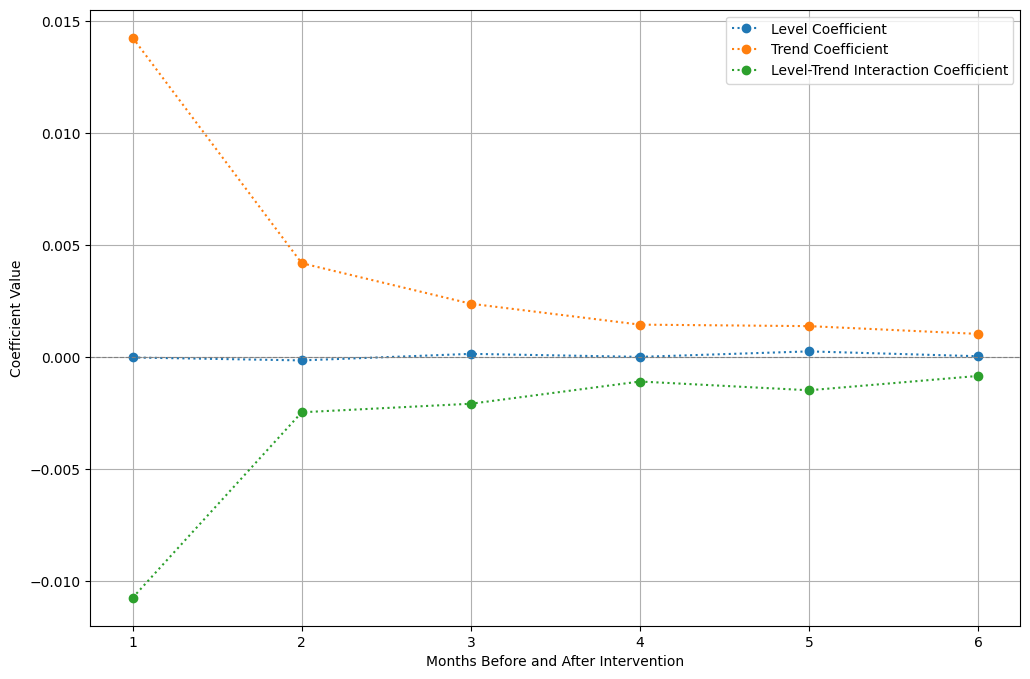

Coefficient visualization saved as 'coefficients_visualization.png'.


In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_farright_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_farright_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2021, 10, 1, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

months_list = [1, 2, 3, 4, 5, 6]

# Lists to store results for visualization
levels, trends, level_trends = [], [], []

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Extract the coefficients for level, trend, and level_trend
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    # Print results
    print(f"\nResults for {months} months before and after the intervention date:")
    print(results.summary())

    return data

# Run the analysis for each time frame
for months in months_list:
    data = run_analysis(months)

# Visualization of Results
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level Coefficient')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend Coefficient')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction Coefficient')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Coefficients Across Different Time Frames')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('far-right_oct12021.png')
plt.show()

print("Coefficient visualization saved as 'coefficients_visualization.png'.")

**October 1st 2020 MLA**

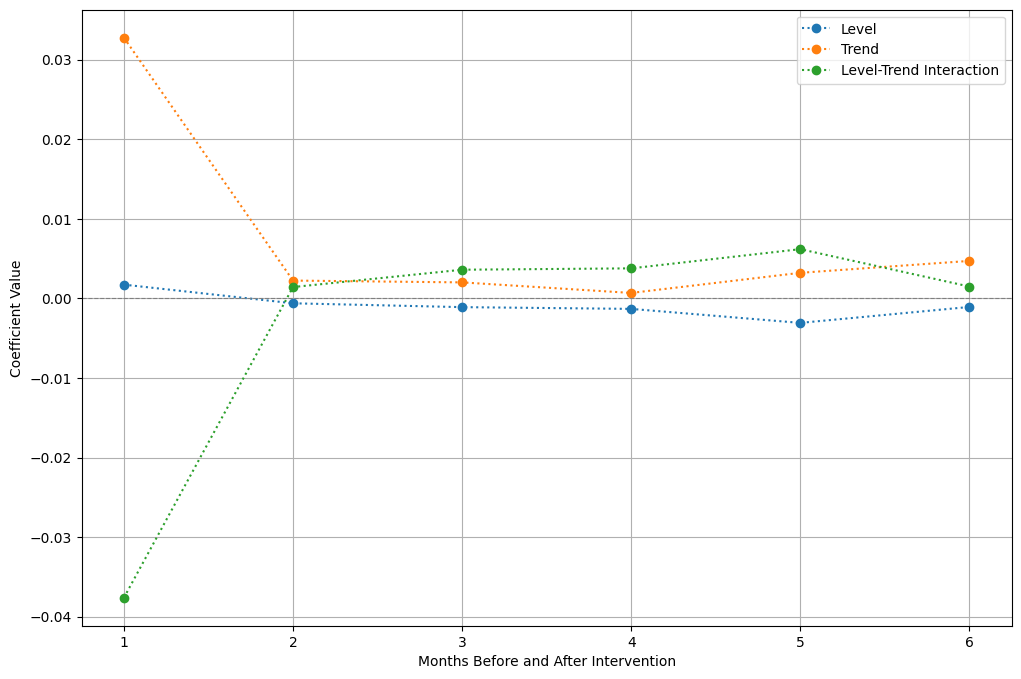

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil import tz

# Load data
follower_file_path = '/content/final_follower_mla_count_df.csv'
tweet_count_file_path = '/content/statuses_count_per_day_mla_count_df.csv'

follower_data = pd.read_csv(follower_file_path, index_col=0, parse_dates=True).bfill()
tweet_count_data = pd.read_csv(tweet_count_file_path, index_col=0, parse_dates=True).bfill()

# Define the intervention date
intervention_date = datetime(2021, 10, 1, tzinfo=tz.tzutc())

# Convert follower and tweet count data to long format
follower_data_long = follower_data.stack().reset_index()
follower_data_long.columns = ['date', 'account', 'followers']

tweet_count_data_long = tweet_count_data.stack().reset_index()
tweet_count_data_long.columns = ['date', 'account', 'statuses_count']

# Merge follower and tweet count data
combined_data = pd.merge(follower_data_long, tweet_count_data_long, on=['date', 'account'], how='left')

# Ensure 'date' is in DateTime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Lists to store coefficients
levels = []
trends = []
level_trends = []

# Months to analyze
months_list = [1, 2, 3, 4, 5, 6]

def run_analysis(months):
    start_date = intervention_date - pd.DateOffset(months=months)
    end_date = intervention_date + pd.DateOffset(months=months)
    data = combined_data[(combined_data['date'] >= start_date) & (combined_data['date'] <= end_date)].copy()

    # Create lagged variables
    dgb = data.groupby('account')
    data['previous_follower_count'] = dgb['followers'].shift(1)
    data['previous_tweet_count'] = dgb['statuses_count'].shift(1)

    # Remove rows with non-positive values for log transformation
    data = data[(data['followers'] > 0) & (data['previous_follower_count'] > 0) &
                (data['statuses_count'] > 0) & (data['previous_tweet_count'] > 0)].copy()

    # Create level, trend, and level_trend variables
    data['level'] = (data['date'] >= intervention_date).astype(int)
    start_of_period = data['date'].min()
    data['trend'] = (data['date'] - start_of_period).dt.days / 365
    data['level_trend'] = data['level'] * data['trend']

    # Log transformations (only for positive values)
    data['log_followers'] = np.log2(data['followers'])
    data['log_previous_follower_count'] = np.log2(data['previous_follower_count'])
    data['log_tweet_count'] = np.log2(data['statuses_count']) - np.log2(data['previous_tweet_count'])

    # Create dummy variables for each account
    account_dummies = pd.get_dummies(data['account'], prefix='account').astype(int)

    # Define independent variables
    exog = pd.concat([data[['log_previous_follower_count', 'log_tweet_count', 'level', 'trend', 'level_trend']], account_dummies], axis=1)

    # Fit model
    model = sm.OLS(data['log_followers'], exog)
    results = model.fit()

    # Store coefficients
    levels.append(results.params['level'])
    trends.append(results.params['trend'])
    level_trends.append(results.params['level_trend'])

    return data

# Run the analysis for each month
for months in months_list:
    data = run_analysis(months)

# Visualization
plt.figure(figsize=(12, 8))
plt.plot(months_list, levels, marker='o',linestyle='dotted',  label='Level')
plt.plot(months_list, trends, marker='o',linestyle='dotted',  label='Trend')
plt.plot(months_list, level_trends, marker='o',linestyle='dotted',  label='Level-Trend Interaction')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
#plt.title('Effect Coefficients for MLA Accounts')
plt.xlabel('Months Before and After Intervention')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.savefig('mla_oct12021.png')
plt.show()
